In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
import copy
import matplotlib.ticker as ticker
import matplotlib as mpl
from scipy.optimize import minimize
from scipy.integrate import odeint
from matplotlib.ticker import FuncFormatter
%matplotlib notebook

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [2]:
svr = 0.174
D = 0.005
dosage = 1.04e-8 / 0.62
pf = 43.12081770456273  # see prefactor notebook

In [3]:
def lighten(color, amount=1.8):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

### Equilibrium model

In [4]:
def concentration_tree(d, cfrac_smfrac):
    
    """
    d = total protein
    
    Concentrations described by a series of fractions (0-1)
    
    c (cfrac)
    s
        m (smfrac)
        n

    """
    
    cfrac, smfrac = [1 / (1 + np.exp(- i)) for i in cfrac_smfrac]
    c = d * cfrac
    s = d * (1 - cfrac)
    m = s * smfrac / (svr*D)
    n = s * (1 - smfrac) / (svr*D)  
    return c, m, n # concentrations


def calc_loss(cfrac_smfrac, dosage, ka, km, kn):

    # Concentrations
    c, m, n = concentration_tree(dosage, cfrac_smfrac)
        
    # Chemical potentials
    muc = np.log(c) - 0.5 * np.log(1 + 2 * ka * c + np.sqrt(1 + 4 * ka * c))
    mum = np.log(m) - 0.5 * np.log(1 + 2 * ka * m + np.sqrt(1 + 4 * ka * m)) - np.log(km)
    mun = np.log(n) - 0.5 * np.log(1 + 2 * ka * n + np.sqrt(1 + 4 * ka * n)) - np.log(kn)

    # Loss
    mu_all = np.array([muc, mum, mun])
    loss = np.sum((mu_all[:, np.newaxis] - mu_all[np.newaxis, :]) ** 2)
        
    return loss


def func_equilibrium(km, ka, kn):

    # Optimise
    res = minimize(calc_loss, x0=[0, 0], args=(dosage, ka, km, kn)).x

    # Get concentrations
    c, m, n = concentration_tree(dosage, res)
    return [c, m, n]

###  Kinetic model

In [5]:
from scipy.integrate import odeint

def kon(c, km, ka, pf=pf):
    mu_c = np.log(c) - 0.5 * np.log(2 * ka * c + np.sqrt(4 * ka * c + 1) + 1)
    s_on = np.exp(mu_c)
    kon = s_on / c
    return kon * pf


def koff(m, km, ka, pf=pf):
    mu_m = np.log(m) - np.log(km) - 0.5 * np.log(2 * ka * m + np.sqrt(4 * ka * m + 1) + 1)
    s_off = np.exp(mu_m)
    koff = s_off / m
    return koff * pf


def dxdt(X, ka, km, kn):
    c = X[0]
    m = X[1]
    n = X[2]

    r = np.zeros(4)
    r[0] = kon(c, km, ka) * c  # onto membrane
    r[1] = koff(m, km, ka) * m  # off membrane
    r[2] = kon(c, kn, ka) * c  # onto endosomes
    r[3] = koff(n, kn, ka) * n  # off endosomes

    dc = svr * D * (- r[0] + r[1] - r[2] + r[3])
    dm = + r[0] - r[1]
    dn = + r[2] - r[3]

    return dc, dm, dn

def func_kinetic(km, ka, kn, timepoints, x0=None):
    
    # Initial conditions
    if x0 is None:
        x0 = [dosage, 1e-100, 1e-100]

    # Solve
    def ode_func(X, t=0):
        return dxdt(X, ka=ka, km=km, kn=kn)

    sol = odeint(ode_func, x0, t=timepoints)
    return sol

### Changing wd

In [6]:
def _fake_log(x, pos):
    return r'$10^{%d}$' % (x)
fake_log = FuncFormatter(_fake_log)

<IPython.core.display.Javascript object>


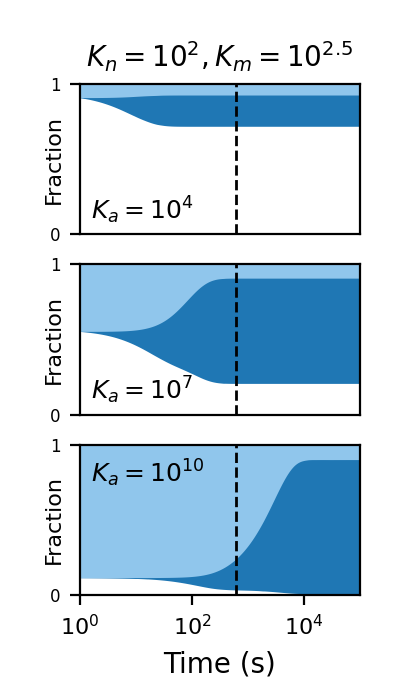

In [7]:
kn = 2
km = 2.5
ka_vals = [4, 7, 10]
tmin, tmax = 0, 5

timepoints = 10 ** np.linspace(tmin, tmax, 501)
sol0 = np.zeros([len(ka_vals), 3])
sol = np.zeros([len(ka_vals), len(timepoints), 3])
solinf = np.zeros([len(ka_vals), 3])
for i, ka in enumerate(ka_vals):
    
    # Time zero
    sol0[i, :] = func_equilibrium(km=1, ka=10 ** ka, kn=10 ** kn)
    
    # Timelapse
    sol[i, :, :] = func_kinetic(km=10 ** km, ka=10 ** ka, kn=10 ** kn, x0=sol0[i, :], timepoints=timepoints)
    
    # Time infinity
    solinf[i, :] = func_equilibrium(km=10 ** km, ka=10 ** ka, kn=10 ** kn)

    
fig, axs = plt.subplots(3, 1)
for i, (ax, s) in enumerate(zip(axs, sol)):
    ax.fill_between(x=np.log10(timepoints), y1=0, y2=s[:, 0]/ dosage, color='w')
    ax.fill_between(x=np.log10(timepoints), y1=s[:, 0] / dosage, 
                    y2=s[:, 0] / dosage + s[:, 1] * svr * D / dosage, color='tab:blue')
    ax.fill_between(x=np.log10(timepoints), y1=1, y2 = 1 - s[:, 2] * svr * D / dosage, color=lighten('tab:blue'))
    ax.set_ylim(0, 1)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Fraction', fontsize=8, labelpad=-5)
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=6)
    ax.axvline(np.log10(600), linestyle='--', c='k', linewidth=1)


axs[0].text(x=tmin + 0.2, y=0.1, s=r'$K_a=10^{%s}$' % ka_vals[0], fontsize=9)
axs[1].text(x=tmin + 0.2, y=0.1, s=r'$K_a=10^{%s}$' % ka_vals[1], fontsize=9)
axs[2].text(x=tmin + 0.2, y=0.75, s=r'$K_a=10^{%s}$' % ka_vals[2], fontsize=9)    
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].xaxis.set_major_formatter(fake_log)
axs[2].set_xlabel('Time (s)')
axs[0].set_title(r'$K_n=10^{%s}, K_m=10^{%s}$' % (kn, km), fontsize=10)
fig.set_size_inches(2, 3.5)
fig.subplots_adjust(left=0.2, bottom=0.15)
fig.savefig('Figs/timelapse.png', dpi=600, transparent=True)

### Pie chart grid

599.7910762555094


/Users/blandt/anaconda3/anaconda3/envs/membranequant/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


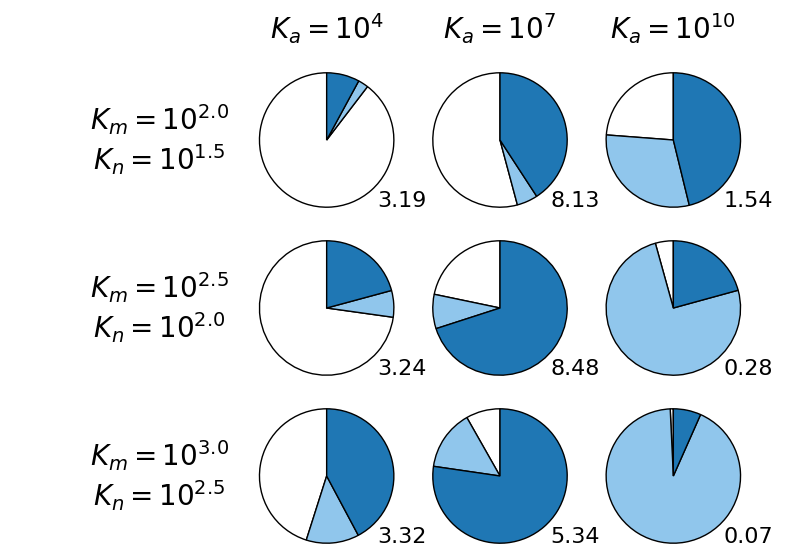

1.0000000000000173
1.0000000000000007
0.9999999999999998
1.0000000000000016
1.0000000000000058
1.0
1.0000000000000053
1.0
0.999999999999929


In [8]:
kas = [4, 7, 10]
kms = [2.0, 2.5, 3.0]

timepoints = 10 ** np.linspace(0, 6, 1001)
sol = np.zeros([len(kms), len(kas), 3])
a = np.argmin(abs(timepoints - 600))
print(timepoints[a])
for i, km in enumerate(kms):
    for j, ka in enumerate(kas):
        sol0 = func_equilibrium(km=1, ka=10**ka, kn=10 ** (km - 0.5))
        sol[i, j, :] = func_kinetic(km=10**km, ka=10**ka, kn=10 ** (km - 0.5), x0=sol0, timepoints=timepoints)[a]
   
def panel(ax, i, j):
    s = sol[i, j]
    c = s[0] / dosage
    m = s[1] * D * svr / dosage
    n = s[2] * D * svr / dosage
    print(c + m + n)
    ax.pie([c, n, m], startangle=90, colors=['w', lighten('tab:blue'), 'tab:blue'], wedgeprops={'linewidth': 0.5, 
                                                                                         'edgecolor': 'k'})
    ratio = m / n
    ax.text(0.75, -1, f'{ratio:.2f}', fontsize=8)
    

fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        panel(ax[i][j], i, j)

ax[0][0].set_title(r'$K_a = 10^{%s}$' % kas[0], fontsize=10) 
ax[0][1].set_title(r'$K_a = 10^{%s}$' % kas[1], fontsize=10) 
ax[0][2].set_title(r'$K_a = 10^{%s}$' % kas[2], fontsize=10) 
ax[0][0].set_ylabel(r'$K_m = 10^{%s}$' % kms[0] + '\n' + r'$K_n = 10^{%s}$' % (kms[0] - 0.5), 
                    rotation=0, ha='center', va='center', labelpad=30) 
ax[1][0].set_ylabel(r'$K_m = 10^{%s}$' % kms[1] + '\n' + r'$K_n = 10^{%s}$' % (kms[1] - 0.5), 
                    rotation=0, ha='center', va='center', labelpad=30) 
ax[2][0].set_ylabel(r'$K_m = 10^{%s}$' % kms[2] + '\n' + r'$K_n = 10^{%s}$' % (kms[2] - 0.5), 
                    rotation=0, ha='center', va='center', labelpad=30) 

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig('Figs/pie_mp.png', dpi=600, transparent=True)